<a href="https://colab.research.google.com/github/ayhan-pixel/BWM_fund/blob/main/FOMC_BWM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install PyMuPDF

import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import fitz
from tqdm import tqdm
import os

# Get year input from user
start_year = int(input("Enter start year (e.g., 2020): "))
end_year = int(input("Enter end year (e.g., 2025): "))

headers = {'User-Agent': 'Mozilla/5.0'}
base_url = "https://www.federalreserve.gov"

valid_years = set(range(start_year, end_year + 1))

minutes_data = []

# Part 1: Historical Data
archive_url = f"{base_url}/monetarypolicy/fomc_historical_year.htm"
response = requests.get(archive_url, headers=headers)
soup = BeautifulSoup(response.content, "html.parser")
year_links = soup.find_all('a', href=re.compile(r'fomchistorical20\d{2}.htm'))

filtered_links = []
for link in year_links:
    year = int(re.findall(r'20\d{2}', link['href'])[0])
    if year in valid_years:
        filtered_links.append(f"{base_url}{link['href']}")

print(f"\nFound {len(filtered_links)} historical year pages...\n")

for year_page in tqdm(filtered_links, desc="Scraping Historical Pages"):
    try:
        year_response = requests.get(year_page, headers=headers)
        year_soup = BeautifulSoup(year_response.content, "html.parser")
        meeting_links = year_soup.find_all('a', href=re.compile(r'fomc.*\d{8}\.(htm|pdf)', re.IGNORECASE))

        for link in meeting_links:
            href = link['href']
            full_url = f"{base_url}{href}"
            date_match = re.search(r'(\d{8})', href)

            if date_match:
                date_str = date_match.group(1)
                date = pd.to_datetime(date_str, format='%Y%m%d')
                if date.year not in valid_years:
                    continue

                try:
                    if href.endswith(".htm"):
                        meeting_response = requests.get(full_url)
                        meeting_soup = BeautifulSoup(meeting_response.text, 'html.parser')
                        content_div = meeting_soup.find('div', id='content') or meeting_soup.find('div', class_="col-xs-12 col-sm-8 col-md-8")
                        meeting_content = content_div.get_text(strip=True) if content_div else ""

                    elif href.endswith(".pdf"):
                        pdf_response = requests.get(full_url)
                        with open("temp.pdf", 'wb') as f:
                            f.write(pdf_response.content)
                        pdf_doc = fitz.open("temp.pdf")
                        meeting_content = ""
                        for page in pdf_doc:
                            meeting_content += page.get_text()

                    if meeting_content and len(meeting_content.strip()) > 100:
                        minutes_data.append({
                            "URL": full_url,
                            "Date": date,
                            "Month": date.month,
                            "Year": date.year,
                            "Day": date.day,
                            "Content": meeting_content
                        })

                except Exception as e:
                    print(f"Failed to fetch historical {full_url}: {e}")

    except Exception as e:
        print(f"Failed to open year page {year_page}: {e}")

# Part 2: Main Calendar
calendar_url = f"{base_url}/monetarypolicy/fomccalendars.htm"
resp = requests.get(calendar_url, headers=headers)
soup = BeautifulSoup(resp.content, "html.parser")
calendar_links = soup.find_all('a', href=re.compile(r'fomc.*\d{8}\.(htm|pdf)', re.IGNORECASE))

for link in tqdm(calendar_links, desc="Scraping Calendar Pages"):
    href = link['href']
    full_url = f"{base_url}{href}"
    date_match = re.search(r'(\d{8})', href)
    if date_match:
        date_str = date_match.group(1)
        date = pd.to_datetime(date_str, format='%Y%m%d')
        if date.year not in valid_years:
            continue

        try:
            if href.endswith(".htm"):
                r = requests.get(full_url)
                soup_page = BeautifulSoup(r.text, 'html.parser')
                div = soup_page.find('div', id='content') or soup_page.find('div', class_='col-xs-12 col-sm-8 col-md-8')
                content = div.get_text(strip=True) if div else ""

            elif href.endswith(".pdf"):
                pdf_resp = requests.get(full_url)
                with open("temp.pdf", "wb") as f:
                    f.write(pdf_resp.content)
                pdf_doc = fitz.open("temp.pdf")
                content = ""
                for page in pdf_doc:
                    content += page.get_text()

            if content and len(content.strip()) > 100:
                minutes_data.append({
                    "URL": full_url,
                    "Date": date,
                    "Month": date.month,
                    "Year": date.year,
                    "Day": date.day,
                    "Content": content
                })

        except Exception as e:
            print(f"Failed to fetch calendar {full_url}: {e}")

# Final cleanup and save
if os.path.exists("temp.pdf"):
    os.remove("temp.pdf")

df = pd.DataFrame(minutes_data)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=False).reset_index(drop=True)

df.to_csv("fomc_minutes_{}_{}_clean.csv".format(start_year, end_year), index=False, encoding="utf-8")
print(f"\nFinal Dataset: {df.shape[0]} transcripts saved to 'fomc_minutes_{start_year}_{end_year}_clean.csv'")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 42.6 MB/s eta 0:00:00
Enter start year (e.g., 2020): 2020
Enter end year (e.g., 2025): 2025

Found 0 historical year pages...



Scraping Historical Pages: 0it [00:00, ?it/s]
Scraping Calendar Pages:  51%|█████▏    | 97/189 [00:31<00:23,  3.85it/s]

Failed to fetch calendar https://www.federalreserve.govhttps://www.federalreserve.gov/monetarypolicy/fomcpresconf20220316.htm: HTTPSConnectionPool(host='www.federalreserve.govhttps', port=443): Max retries exceeded with url: /www.federalreserve.gov/monetarypolicy/fomcpresconf20220316.htm (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7fe065cfe2d0>: Failed to resolve 'www.federalreserve.govhttps' ([Errno -2] Name or service not known)"))


Scraping Calendar Pages: 100%|██████████| 189/189 [00:54<00:00,  3.46it/s]



Final Dataset: 188 transcripts saved to 'fomc_minutes_2020_2025_clean.csv'


In [2]:
df.shape


(188, 6)

In [3]:
df.sample(10)

,URL,Date,Month,Year,Day,Content
147,https://www.federalreserve.gov/monetarypolicy/...,2021-04-28,4,2021,28,Minutes of the Federal Open Market Committee \...
41,https://www.federalreserve.gov/monetarypolicy/...,2024-09-18,9,2024,18,"For release at 2:00 p.m., EDT, September 18, 2..."
152,https://www.federalreserve.gov/monetarypolicy/...,2021-03-17,3,2021,17,HomeMonetary PolicyFederal Open Market Committ...
26,https://www.federalreserve.gov/monetarypolicy/...,2025-03-19,3,2025,19,HomeMonetary PolicyFederal Open Market Committ...
15,https://www.federalreserve.gov/monetarypolicy/...,2025-06-18,6,2025,18,HomeMonetary PolicyFederal Open Market Committ...
40,https://www.federalreserve.gov/monetarypolicy/...,2024-09-18,9,2024,18,HomeMonetary PolicyFederal Open Market Committ...
18,https://www.federalreserve.gov/monetarypolicy/...,2025-06-18,6,2025,18,\n \nFOMC\n \n \n \nFEDERAL RESERVE SYSTEM \n...
81,https://www.federalreserve.gov/monetarypolicy/...,2023-06-14,6,2023,14,\nMinutes of the Federal Open Market Committe...
94,https://www.federalreserve.gov/monetarypolicy/...,2022-12-14,12,2022,14,\n \nMinutes of the Federal Open Market Commi...
106,https://www.federalreserve.gov/monetarypolicy/...,2022-09-21,9,2022,21,HomeMonetary PolicyFederal Open Market Committ...


In [4]:
df_sorted_asc = df.sort_values(by='Date', ascending=True).reset_index(drop=True)
df_sorted_asc.head(10)

,URL,Date,Month,Year,Day,Content
0,https://www.federalreserve.gov/monetarypolicy/...,2020-01-29,1,2020,29,HomeMonetary PolicyFederal Open Market Committ...
1,https://www.federalreserve.gov/monetarypolicy/...,2020-01-29,1,2020,29,HomeMonetary PolicyFederal Open Market Committ...
2,https://www.federalreserve.gov/monetarypolicy/...,2020-01-29,1,2020,29,Minutes of the Federal Open Market Committee \...
3,https://www.federalreserve.gov/monetarypolicy/...,2020-03-03,3,2020,3,HomeMonetary PolicyFederal Open Market Committ...
4,https://www.federalreserve.gov/monetarypolicy/...,2020-03-15,3,2020,15,\n \nMinutes of the Federal Open Market Commi...
5,https://www.federalreserve.gov/monetarypolicy/...,2020-03-15,3,2020,15,HomeMonetary PolicyFederal Open Market Committ...
6,https://www.federalreserve.gov/monetarypolicy/...,2020-03-15,3,2020,15,HomeMonetary PolicyFederal Open Market Committ...
7,https://www.federalreserve.gov/monetarypolicy/...,2020-04-29,4,2020,29,HomeMonetary PolicyFederal Open Market Committ...
8,https://www.federalreserve.gov/monetarypolicy/...,2020-04-29,4,2020,29,\nMinutes of the Federal Open Market Committe...
9,https://www.federalreserve.gov/monetarypolicy/...,2020-04-29,4,2020,29,HomeMonetary PolicyFederal Open Market Committ...


In [5]:
import string
from wordcloud import STOPWORDS

def calc_snr_ratio(text):
    words = text.split()
    if not words:
        return 0
    unique = len(set(words))
    total = len(words)
    return unique / (total + 1e-5)

def calc_stopword_ratio(text):
    words = text.split()
    if not words:
        return 0
    stop_count = sum(1 for word in words if word.lower() in STOPWORDS)
    return stop_count / len(words)

def calc_redundancy_ratio(text):
    words = text.split()
    if not words:
        return 0
    return 1 - (len(set(words)) / len(words))

def calc_special_char_density(text):
    specials = [char for char in text if char in string.punctuation]
    return len(specials) / (len(text) + 1e-5)



df_noise = df.copy()
df_noise = df_noise[['Date', 'Content']].dropna().copy()

df_noise['SNR_Ratio'] = df_noise['Content'].apply(calc_snr_ratio)
df_noise['StopWord_Ratio'] = df_noise['Content'].apply(calc_stopword_ratio)
df_noise['Redundancy_Ratio'] = df_noise['Content'].apply(calc_redundancy_ratio)
df_noise['SpecialChar_Density'] = df_noise['Content'].apply(calc_special_char_density)



In [6]:
df_plot = df_noise.sort_values(by="Date", ascending=False).head(10).sort_values(by="Date")
df_plot.head()

,Date,Content,SNR_Ratio,StopWord_Ratio,Redundancy_Ratio,SpecialChar_Density
6,2025-09-17,HomeMonetary PolicyFederal Open Market Committ...,0.280374,0.349662,0.719626,0.022926
7,2025-09-17,\n \nFOMC\n \n \n \nFEDERAL RESERVE SYSTEM \n...,0.269201,0.341350,0.730799,0.021013
8,2025-09-17,HomeMonetary PolicyFederal Open Market Committ...,0.272539,0.371244,0.727461,0.056577
9,2025-09-17,"For release at 2:00 p.m., EDT, September 17, 2...",0.181212,0.269038,0.818788,0.041410
3,2025-10-29,HomeMonetary PolicyFederal Open Market Committ...,0.258220,0.354635,0.741780,0.021541


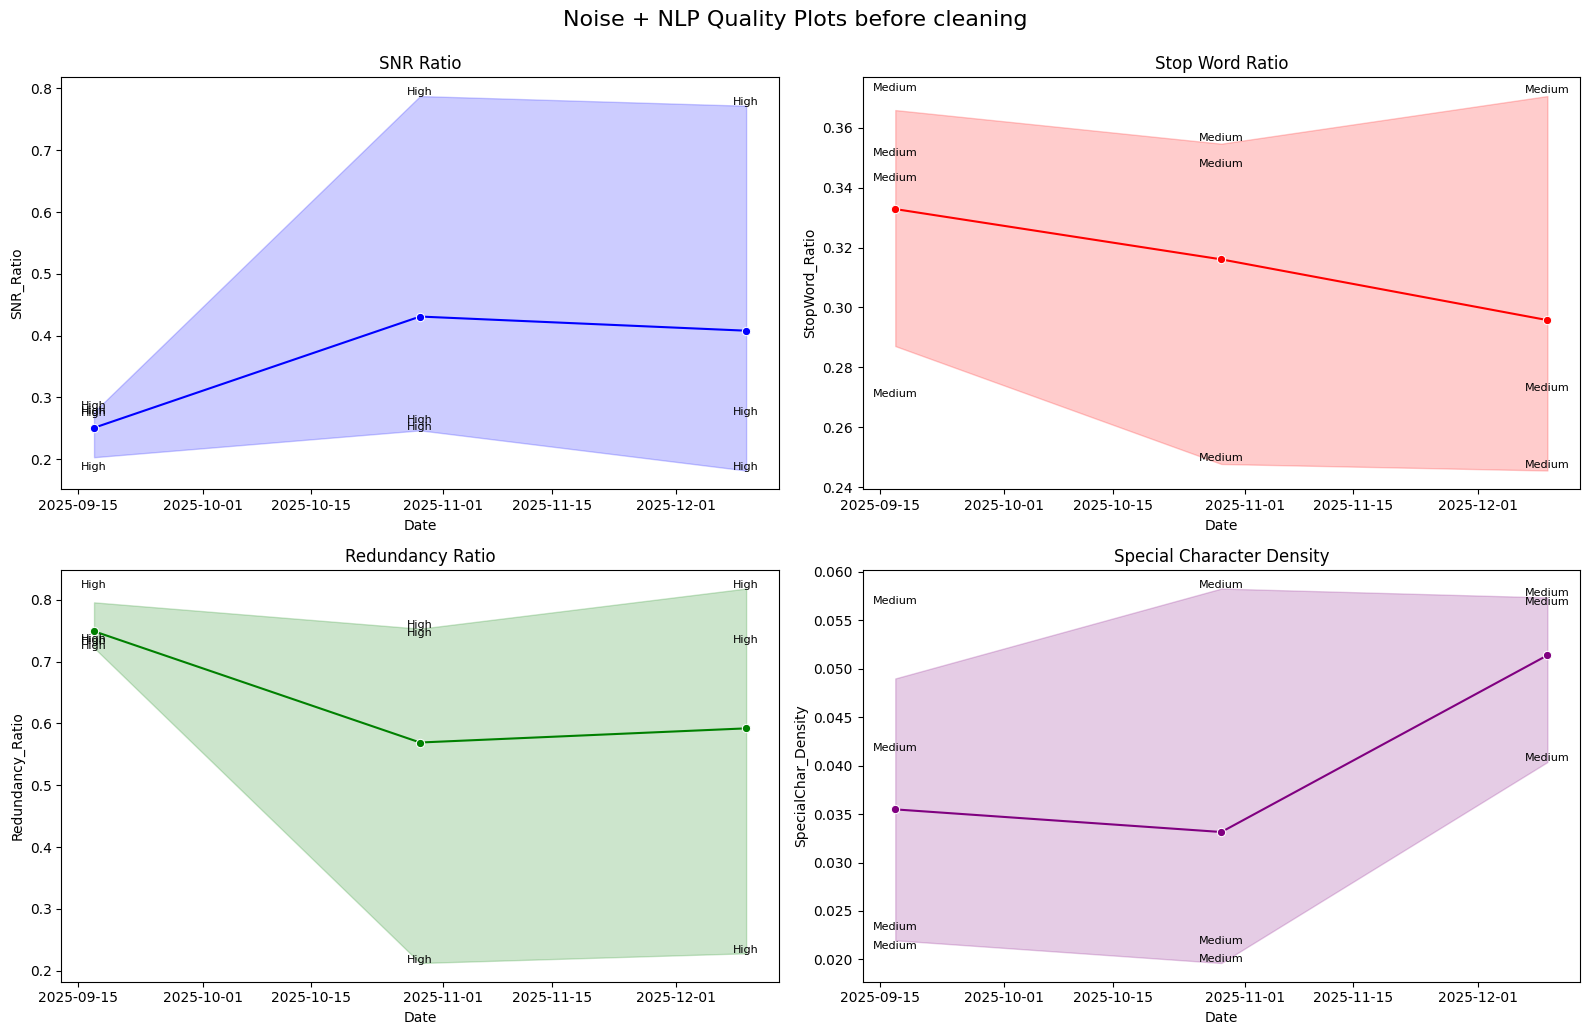

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: SNR
sns.lineplot(data=df_plot, x="Date", y="SNR_Ratio", marker='o', ax=axs[0, 0], color='blue')
axs[0, 0].set_title("SNR Ratio")
for i, val in enumerate(df_plot['SNR_Ratio']):
    axs[0, 0].text(df_plot['Date'].iloc[i], val + 0.001, "High", ha='center', fontsize=8)

# Plot 2: Stop Word Ratio
sns.lineplot(data=df_plot, x="Date", y="StopWord_Ratio", marker='o', ax=axs[0, 1], color='red')
axs[0, 1].set_title("Stop Word Ratio")
for i, val in enumerate(df_plot['StopWord_Ratio']):
    axs[0, 1].text(df_plot['Date'].iloc[i], val + 0.001, "Medium", ha='center', fontsize=8)

# Plot 3: Redundancy
sns.lineplot(data=df_plot, x="Date", y="Redundancy_Ratio", marker='o', ax=axs[1, 0], color='green')
axs[1, 0].set_title("Redundancy Ratio")
for i, val in enumerate(df_plot['Redundancy_Ratio']):
    axs[1, 0].text(df_plot['Date'].iloc[i], val + 0.0005, "High", ha='center', fontsize=8)

# Plot 4: Special Characters
sns.lineplot(data=df_plot, x="Date", y="SpecialChar_Density", marker='o', ax=axs[1, 1], color='purple')
axs[1, 1].set_title("Special Character Density")
for i, val in enumerate(df_plot['SpecialChar_Density']):
    axs[1, 1].text(df_plot['Date'].iloc[i], val + 0.0001, "Medium", ha='center', fontsize=8)

plt.tight_layout()
plt.suptitle("Noise + NLP Quality Plots before cleaning", fontsize=16, y=1.03)
plt.show()

Finbert

In [8]:
!pip install transformers
!pip install torch
!pip install sentencepiece


In [9]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Load FinBERT model and tokenizer
finbert_model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(finbert_model_name)
model = AutoModelForSequenceClassification.from_pretrained(finbert_model_name)

# Create sentiment analysis pipeline
finbert_sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [10]:
import numpy as np

def get_finbert_sentiment(text, max_chunk=512):

    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt_tab', quiet=True)

    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ""

    for s in sentences:
        if len((current_chunk + " " + s).split()) <= max_chunk:
            current_chunk += " " + s
        else:
            chunks.append(current_chunk.strip())
            current_chunk = s
    if current_chunk:
        chunks.append(current_chunk.strip())

    pos_scores, neg_scores, neu_scores = [], [], []
    for chunk in chunks:
        try:
            result = finbert_sentiment(chunk)[0]
            label = result['label']
            score = result['score']
            if label == "positive":
                pos_scores.append(score)
                neg_scores.append(0)
                neu_scores.append(0)
            elif label == "negative":
                pos_scores.append(0)
                neg_scores.append(score)
                neu_scores.append(0)
            else:  # neutral
                pos_scores.append(0)
                neg_scores.append(0)
                neu_scores.append(score)
        except Exception as e:
            print(f"Error processing chunk: {e}")

    return {
        "Positive": np.mean(pos_scores),
        "Negative": np.mean(neg_scores),
        "Neutral": np.mean(neu_scores)
    }


In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch
import numpy as np
from tqdm import tqdm

finbert_model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(finbert_model_name)
model = AutoModelForSequenceClassification.from_pretrained(finbert_model_name)
model.eval()


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [15]:
def get_finbert_sentiment_safe(text, max_length=512):


    from nltk.tokenize import sent_tokenize
    import nltk
    nltk.download('punkt_tab', quiet=True)

    sentences = sent_tokenize(text)
    chunk_texts = []
    chunk = ""

    for s in sentences:
        if len((chunk + " " + s).split()) <= max_length:
            chunk += " " + s
        else:
            chunk_texts.append(chunk.strip())
            chunk = s
    if chunk:
        chunk_texts.append(chunk.strip())

    pos_scores, neg_scores, neu_scores = [], [], []

    for t in chunk_texts:
        inputs = tokenizer(t, return_tensors="pt", truncation=True, padding=True, max_length=max_length).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()[0]

            pos_scores.append(probs[0])
            neu_scores.append(probs[1])
            neg_scores.append(probs[2])

    return {
        "Positive": float(np.mean(pos_scores)),
        "Neutral": float(np.mean(neu_scores)),
        "Negative": float(np.mean(neg_scores))
    }

In [16]:
tqdm.pandas()
df_sentiment = df_sorted_asc.copy()
df_sentiment['FinBERT_Sentiment'] = df_sentiment['Content'].progress_apply(get_finbert_sentiment_safe)
df_sentiment[['Positive', 'Neutral', 'Negative']] = pd.json_normalize(df_sentiment['FinBERT_Sentiment'])


100%|██████████| 188/188 [01:20<00:00,  2.34it/s]


In [17]:
import pandas as pd
from google.colab import files

csv_filename = "fomc_finbert_sentiment.csv"
df_sentiment.to_csv(csv_filename, index=False, encoding="utf-8")

files.download(csv_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
df_sentiment

,URL,Date,Month,Year,Day,Content,FinBERT_Sentiment,Positive,Neutral,Negative
0,https://www.federalreserve.gov/monetarypolicy/...,2020-01-29,1,2020,29,HomeMonetary PolicyFederal Open Market Committ...,"{'Positive': 0.7249224185943604, 'Neutral': 0....",0.724922,1.979673e-01,7.711025e-02
1,https://www.federalreserve.gov/monetarypolicy/...,2020-01-29,1,2020,29,HomeMonetary PolicyFederal Open Market Committ...,"{'Positive': 0.999992847442627, 'Neutral': 6.2...",0.999993,6.293179e-06,7.766819e-07
2,https://www.federalreserve.gov/monetarypolicy/...,2020-01-29,1,2020,29,Minutes of the Federal Open Market Committee \...,"{'Positive': 0.7560312151908875, 'Neutral': 0....",0.756031,1.596136e-01,8.435518e-02
3,https://www.federalreserve.gov/monetarypolicy/...,2020-03-03,3,2020,3,HomeMonetary PolicyFederal Open Market Committ...,"{'Positive': 0.9999936819076538, 'Neutral': 5....",0.999994,5.601114e-06,7.719661e-07
4,https://www.federalreserve.gov/monetarypolicy/...,2020-03-15,3,2020,15,\n \nMinutes of the Federal Open Market Commi...,"{'Positive': 0.6522451043128967, 'Neutral': 0....",0.652245,1.324647e-02,3.345084e-01
...,...,...,...,...,...,...,...,...,...,...
183,https://www.federalreserve.gov/monetarypolicy/...,2025-10-29,10,2025,29,FOMC\nFEDERAL RESERV E SYSTEM\nMinutes of the ...,"{'Positive': 0.7055214643478394, 'Neutral': 0....",0.705521,1.634041e-01,1.310744e-01
184,https://www.federalreserve.gov/monetarypolicy/...,2025-10-29,10,2025,29,HomeMonetary PolicyFederal Open Market Committ...,"{'Positive': 0.6874662041664124, 'Neutral': 0....",0.687466,1.849357e-01,1.275981e-01
185,https://www.federalreserve.gov/monetarypolicy/...,2025-12-10,12,2025,10,HomeMonetary PolicyFederal Open Market Committ...,"{'Positive': 0.9999048709869385, 'Neutral': 9....",0.999905,9.689858e-07,9.417958e-05
186,https://www.federalreserve.gov/monetarypolicy/...,2025-12-10,12,2025,10,"For release at 2:00 p.m., EST, December 10, 20...","{'Positive': 0.9999647736549377, 'Neutral': 7....",0.999965,7.679527e-07,3.440203e-05


In [26]:
import numpy as np

def compute_compound(pos, neu, neg, alpha=0.001):
    compound = pos - neg

    compound_weighted = compound * (1 - neu)


    return compound_weighted

df_sentiment['Compound'] = df_sentiment.apply(
    lambda row: compute_compound(row['Positive'], row['Neutral'], row['Negative']), axis=1
)

df_sentiment[['Date', 'Positive', 'Neutral', 'Negative', 'Compound']].head()


,Date,Positive,Neutral,Negative,Compound
0,2020-01-29,0.724922,0.197967,7.711025e-02,0.519567
1,2020-01-29,0.999993,0.000006,7.766819e-07,0.999986
2,2020-01-29,0.756031,0.159614,8.435518e-02,0.564467
3,2020-03-03,0.999994,0.000006,7.719661e-07,0.999987
4,2020-03-15,0.652245,0.013246,3.345084e-01,0.313528


In [27]:
df_sentiment["Normalized_Score"].describe()

,Normalized_Score
count,188.000000
mean,0.751182
std,0.274716
min,-0.016298
25%,0.535617
50%,0.890677
75%,0.999992
max,0.999997


In [29]:
df_sentiment.to_csv("fomc_finbert_sentiment_final.csv", index=False, encoding="utf-8")